In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip install konlpy koreanize_matplotlib gensim

### 방법3. 한국어 자연어처리 방법
- 한국어 처리 : Keras (띄어쓰기), (Okt 형태소 분석기 사용하지 않음)
- 토큰 임베딩 : Keras Tokenizer 사용함. (Word2Vec 사용하지 않음)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from konlpy.tag import Okt
from gensim.models import Word2Vec
from collections import Counter

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

In [2]:
df=pd.read_csv("./emergency_call_binary_tokens.csv", encoding="utf-8-sig")
df.head()

Unnamed: 0  id                    document label  \
0           0   1    골목길에서 싸움이 났어요 다친 사람이 있어요    긴급   
1           1   2      교통사고가 발생했는데 상대방이 도주했어요    긴급   
2           2   3      집 근처에서 폭죽 소리가 나고 시끄러워요    경미   
3           3   4  술집에서 손님끼리 다투고 있어요 경찰이 필요해요    긴급   
4           4   5         차에 누가 돌을 던졌어요 잡아주세요    경미   

                                    tokens  
0         ['골목길', '싸움', '나다', '다치다', '사람']  
1  ['교통사고', '발생', '하다', '상대방', '도주', '하다']  
2    ['집', '근처', '폭죽', '소리', '나다', '시끄럽다']  
3  ['술집', '손님', '끼리', '다투다', '경찰', '필요하다']  
4            ['차', '누가', '돌', '던지다', '잡다']

In [5]:
padding_len = 32
embedding_dim = 512

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['document'].apply(lambda x: ' '.join(x)))
sequences = tokenizer.texts_to_sequences(df['document'].apply(lambda x: ' '.join(x)))
X = pad_sequences(sequences, maxlen=padding_len, padding='post')

le = LabelEncoder()
y = le.fit_transform(df['label'])
print(f"X shape: {X.shape}, y shape: {y.shape}")



X shape: (300, 32), y shape: (300,)


In [6]:
vocab_size = len(tokenizer.word_index) + 1
print(f"vocab_size: {vocab_size}")
print(f"max index in sequences: {np.max(X)}")


vocab_size: 361
max index in sequences: 360


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- GAP (GlobalAveragePooling1D)은 padding_len 각각의 embedding_dim을 pooling을 한 이후 최적의 단어를 mean한다.
- Flatten은 padding_len와 embedding_dim을 전체로 섞는다.


In [8]:
model_flat = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padding_len),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_gap = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padding_len),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [9]:
model_dict = {
    'mlp_flat': model_flat,
    'mlp_gap': model_gap }
choice = 'mlp_flat'
model = model_dict[choice]


In [10]:
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
learning_rate=0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=[early_stop], verbose=1)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.5755 - loss: 0.6888 - val_accuracy: 0.4583 - val_loss: 0.7668
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6393 - loss: 0.6388 - val_accuracy: 0.5000 - val_loss: 0.6947
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6536 - loss: 0.6144 - val_accuracy: 0.5000 - val_loss: 0.7001
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7272 - loss: 0.5474 - val_accuracy: 0.5000 - val_loss: 0.7504
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7415 - loss: 0.4766 - val_accuracy: 0.5000 - val_loss: 0.7279
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8281 - loss: 0.4320 - val_accuracy: 0.5417 - val_loss: 0.6904
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9316 - loss: 0.3490 - val_accuracy: 0.5417 - val_loss: 0.6990
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9479 - loss: 0.2725 - val_accuracy: 0.5417 - val_loss: 0.7355

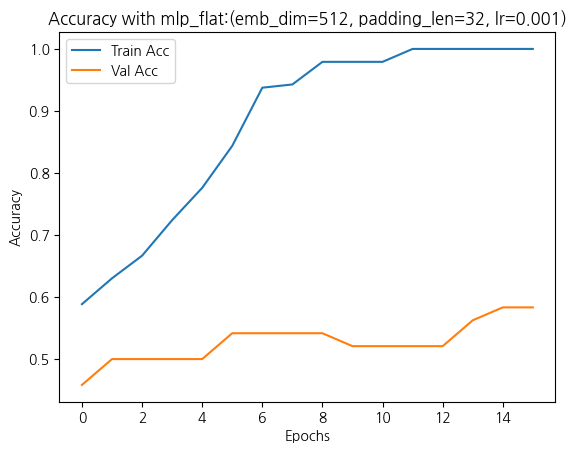

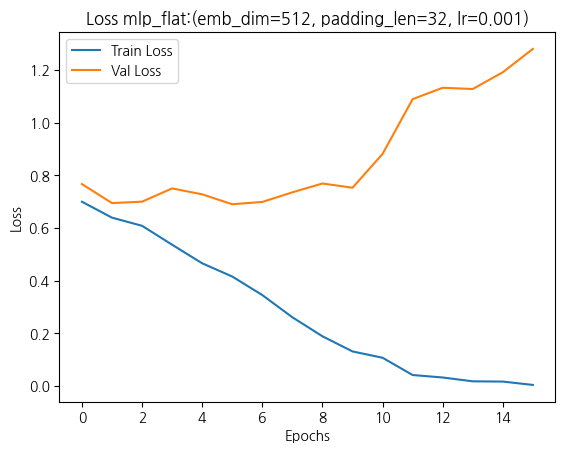

Test Accuracy: 0.5833, Loss: 0.6932


In [11]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')

plt.title(f"Accuracy with {choice}:(emb_dim={embedding_dim}, padding_len={padding_len}, lr={learning_rate})")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Loss {choice}:(emb_dim={embedding_dim}, padding_len={padding_len}, lr={learning_rate})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 최종 평가
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")


## model Flatten

In [12]:
choice = 'mlp_gap'
model = model_dict[choice]

In [13]:
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
learning_rate=0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=[early_stop], verbose=1)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.6536 - loss: 0.6853 - val_accuracy: 0.4583 - val_loss: 0.7057
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6100 - loss: 0.6703 - val_accuracy: 0.4583 - val_loss: 0.7209
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6022 - loss: 0.6710 - val_accuracy: 0.4583 - val_loss: 0.7338
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5905 - loss: 0.6686 - val_accuracy: 0.4583 - val_loss: 0.7377
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6022 - loss: 0.6517 - val_accuracy: 0.4583 - val_loss: 0.7377
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6107 - loss: 0.6522 - val_accuracy: 0.4583 - val_loss: 0.7262
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5957 - loss: 0.6412 - val_accuracy: 0.4583 - val_loss: 0.7165
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6165 - loss: 0.6260 - val_accuracy: 0.4583 - val_loss: 0.7211

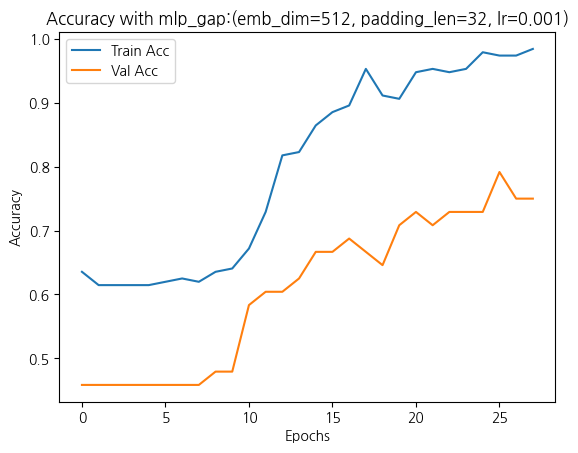

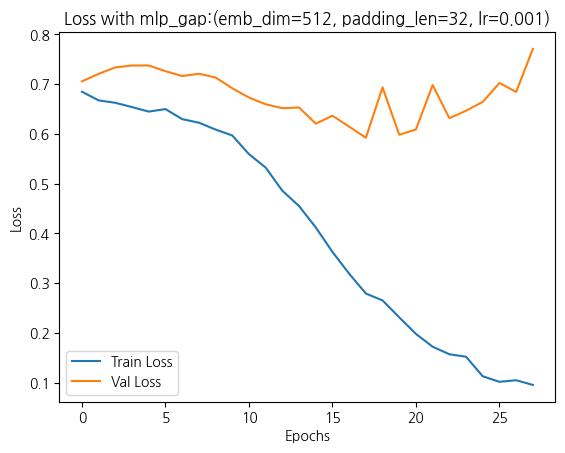

Test Accuracy: 0.6333, Loss: 0.6596


In [14]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title(f"Accuracy with {choice}:(emb_dim={embedding_dim}, padding_len={padding_len}, lr={learning_rate})")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Loss with {choice}:(emb_dim={embedding_dim}, padding_len={padding_len}, lr={learning_rate})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 최종 평가
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")

- (과제1) Flatten와 Gap으로 분류할 경우 최대의 Test Accuracy를 주는 Hyperparameter는?
- (과제2) Keras 토큰화와 OKT() 형태소 분석기를 적용한 한국어 토큰의 영향은 무엇인가?

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
=== 분류 성능 보고서 ===
              precision    recall  f1-score   support

          경미       0.62      0.70      0.66        30
          긴급       0.65      0.57      0.61        30

    accuracy                           0.63        60
   macro avg       0.64      0.63      0.63        60
weighted avg       0.64      0.63      0.63        60



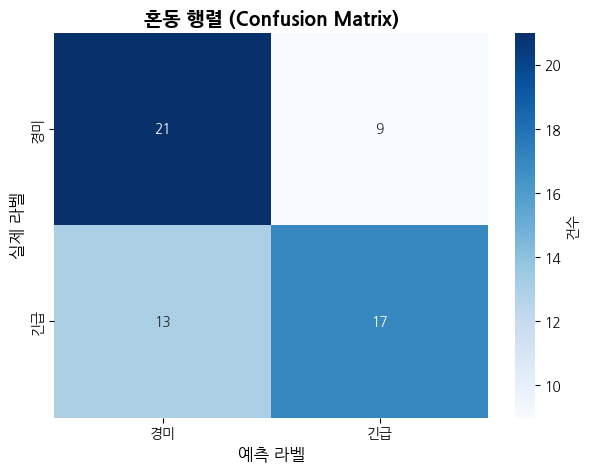

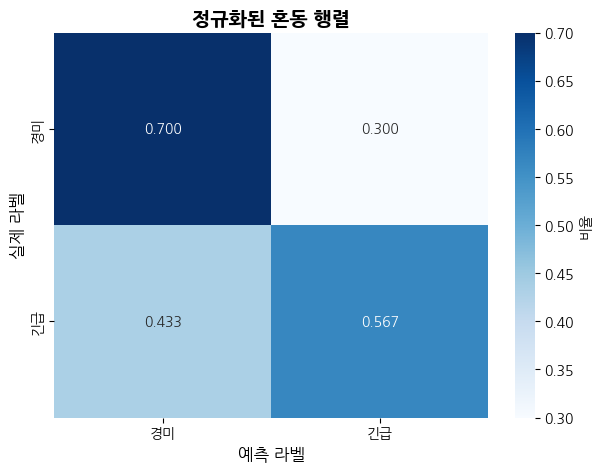

In [15]:

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import koreanize_matplotlib

# Classification Report (한글)
# 예측 수행 (긴급=1, 경미=0 가정)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("=== 분류 성능 보고서 ===")
print(classification_report(y_test, y_pred,
                          target_names=['경미', '긴급']))

# Confusion Matrix 계산 및 시각화
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['경미', '긴급'],
            yticklabels=['경미', '긴급'],
            cbar_kws={'label': '건수'})
plt.title('혼동 행렬 (Confusion Matrix)', fontsize=14, fontweight='bold')
plt.ylabel('실제 라벨', fontsize=12)
plt.xlabel('예측 라벨', fontsize=12)
plt.show()

# 정규화된 Confusion Matrix
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(7, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=['경미', '긴급'],
            yticklabels=['경미', '긴급'],
            cbar_kws={'label': '비율'})
plt.title('정규화된 혼동 행렬', fontsize=14, fontweight='bold')
plt.ylabel('실제 라벨', fontsize=12)
plt.xlabel('예측 라벨', fontsize=12)
plt.show()
